<a href="https://colab.research.google.com/github/triablomanon/MSE233/blob/HW5/MS%26E233_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MS&E 233 (Spring 2025): Homework 5 (due May 14th, 8:00pm)

In this problem set, you will create agents that will bid in an auction for a limited number of advertisement slots. Each of the ad slot $j$ has a "click rate" $a_j$ which is a measure of how likely users will click an ad for the ad slot. This is fixed across all auctions. Also, at each round each bidding agent $i$ is given a "quality score" $s_i$. This is a measure of how good the particular advertisement they want to show. Whether a user clicks on an ad will also depend on the ad's quality score, in particular, if ad $i$ appears in slot $j$, then the probability of click is $a_j\cdot s_i$. However, the bidders don't have access to their quality score ($s_i$) at each auction. Finally, each bidding agent has a fixed "value per click" for each user click. This is fixed across all auctions.

At the begining of a round each bidders submits a single bid. Bidders don't have access to the bids of the other bidders. After this, the agents are ranked based on the product of their "quality score" and "bid" for that round, i.e. $s_i \cdot b_i$. The player with the $j$-th largest score-weighted-bid is then given the $j$-th slot. Then, based on the slot that a bidder gets, they get a click with probability "click rate" x "quality score" = $a_j\cdot s_i$. Finally, bidders are asked to pay their bid for each click that they get. The bidder's utility is the total expected value they get minus the total expected payment they are asked to make, i.e. is bidder $i$ is assigned slot $j$, then they get utility:
\begin{align}
u_i = a_j \cdot s_i \cdot (v_i - b_i)
\end{align}



# Problem 1

## Problem 1.1 Implement EXP3 learning dynamics

At each period the bidders submit a bid and they learn their expected utility from the auction only for the bid that they submitted. Then they update the probability of submitting each bid using the EXP3 update rule.

In [1]:
import numpy as np
# total no. of auctions
T = 10000
# no. of bidders
N = 3
# value of a click for bidders 0, 1, 2 respectively
VALUES = np.array([0.6, 0.5, 0.4])

# click rate for slots 0, 1, 2 respectively
# essentially there are only 2 slots (0 and 1), as slot 2 is useless
CLICK_PROB = np.array([0.5, 0.2, 0])

In [2]:
class Bidder():
    def __init__(self, value, T):
        # (int) represents value per click for the bidder
        self.value = value
        # set of discrete bids the bidder can bid, from [0, value + 0.1] with
        # step size 0.1
        self.bids = np.arange(0, value + 0.1, 0.1)
        # number of possible actions for the bidder
        self.num_actions = len(self.bids)
        # initialization for the possible strategies for the bidder
        # this stores pt in the slides for each period t
        self.strategies = np.ones((T+1, self.num_actions)) * 1 / self.num_actions
        # eta constant for the EXP3 algorithm
        self.eta = 10 * np.sqrt(np.log(self.num_actions)/(self.num_actions * T))
        # counter to keep track of the current bid's time
        self.current_time = 0
        # store total bidder utility
        self.total_utility = 0

    def update(self, utility, bid):
        ''' (2 points) EXP3 update algorithm '''
        # increment time
        self.current_time += 1
        t = self.current_time
        # keep track of total utility of bidder
        # update by adding the current utility to the total utility
        self.total_utility += utility
        # transform utility into a loss. Note that EXP3 requires non-negative
        # losses. `utility` can be assumed to lie in [-1, 1]
        loss = - (utility - 1)

        # find out what action you played and update only for that action
        # because full loss function is not observable
        bid_index = int(bid * 10)

        # construct the proxy loss vector ltproxy in slide 60 of Lecture 10
        ltproxy = np.zeros(self.num_actions)
        ltproxy[bid_index] = loss / self.strategies[t-1, bid_index]

        # EXP3 update based on the loss
        self.strategies[t, :] = self.strategies[t-1, :] * np.exp(-self.eta * ltproxy) / np.sum(self.strategies[t-1, :] * np.exp(-self.eta * ltproxy))

        return self

    def get_bid(self):
        ''' (0.5 points) '''
        # generates a bid randomly based on the previous time period's strategy and returns this
        bid_index = np.random.choice(self.num_actions, p=self.strategies[self.current_time])

        return self.bids[bid_index]

    def get_average_strategy(self):
        # returns average of all strategy
        return np.mean(self.strategies, axis=0)

    def get_avg_utility(self):
        # returns average utility per time period
        return self.total_utility / self.current_time

## Problem 1.2 Calculate regret

In [3]:
def calculate_regret(bidder_scores, bids, actual_utilitites, auction):
    ''' (1.5 points)
    Function to return average regret for each bidder given current bids and utilities

    bidder_scores: the vector of quality scores of the bidders
    bids: the vector of bids of the bidders
    actual_utilities: the utilities that bidders received with their current bids
    auction: the function that simulates the auction, given scores and bids
    '''
    # keep track of best possible utilites for each bidder
    best_utilities = []
    # loop over all bidders
    for i in range(len(bidder_scores)):
        # set best utility for bidder to -infinity first
        best_utility = -np.inf
        for j in np.arange(0, 1.1, 0.1):
            # bidder unilaterally deviates from the old bid to get the new bid
            new_bids = bids.copy()
            new_bids[i] = j

            # find utility using new bids (same as before)
            ij_utilities, _, _ = auction(bidder_scores, new_bids)

            # store the bid utility for bidder i in the best_utility variable
            # if it is the best so far
            best_utility = max(best_utility, ij_utilities[i])

        best_utilities.append(best_utility)
    # compute and return regret
    regret = np.array(best_utilities) - np.array(actual_utilitites)
    return regret

## Problem 1.3 Calculate Optimal Welfare

In [4]:
def optimal_welfare(bidder_scores):
    ''' (1.5 point) Calculates the optimal total welfare, given the quality scores '''
    # Determine the index of the bidder that is allocated each of the slots
    # under the allocation that optimizes the social welfare
    # # Hint: use argsort. Argsort(a) returns an array index, such that a[index]
    # is sorted in increasing order. So index[0] can be viewed as the index
    # of the lowest element of a, index[1] as the index of the second lowest
    # element of a, etc.
    # in the end optimal_allocated_bidder[j] should contain the index of
    # the bidder that is allocated slot j under the optimal welfare allocation.
    optimal_allocated_bidder = np.argsort(bidder_scores * VALUES)[::-1]

    # calculate the click probability a_j that each bidder receives in this
    # allocation
    optimal_bidder_click_prob = bidder_scores.copy()
    for i in range(len(bidder_scores)):
      optimal_bidder_click_prob[optimal_allocated_bidder[i]] = optimal_bidder_click_prob[optimal_allocated_bidder[i]] * CLICK_PROB[i]

    # calculate the total welfare, which is sum_i a_{J(i)} * s_i * v_i
    # where J(i) is the slot allocated to bidder i in the optimal allocation
    welfare = np.sum(optimal_bidder_click_prob * VALUES)

    return welfare

## Problem 1.4 Implement the Learning Dynamics

In [5]:
def run_dynamics(auction, bidders):
    ''' Simulates bidder learning dynamics

    auction: the function that simulates the auction, given scores and bids
    bidders: list of bidder objects

    Returns: avg_welfare, avg_optimal_welfare, avg_revenue, avg_regret
    At the end the bidder objects will have also been updated and contain the
    history of strategies over time.
    '''
    np.random.seed(12345)
    # store total welfare, total optimal welfare, total revenue
    total_welfare, total_optimal_welfare, total_revenue = (0, 0, 0)
    # also store total regret
    # NOTE WE ARE KEEPING TRACK OF REGRET REGARDLESS OF WHETHER THEY ARE POSITIVE OR NEGATIVE
    total_regrets = np.zeros(N)
    # generate random bidder scores for each round from [1/2, 1]
    all_bidder_scores = np.random.uniform(0.5, 1, (T, N))
    # loop for running auctions
    for t in range(T):
        # bidder scores for this round
        bidder_scores = all_bidder_scores[t]
        # generate bids based on current strategy
        bids = np.array([bidder.get_bid() for bidder in bidders])

        # run the auction and get utilities, welfare and revenue
        utilities, welfare, revenue = auction(bidder_scores, bids)

        # calculate the regrets of all bidders using the calculate_regret method
        regrets = calculate_regret(bidder_scores, bids, utilities, auction)

        # update total welfare, total optimal welfare, total revenue, total regret
        total_welfare += welfare
        total_revenue += revenue
        total_regrets += regrets

        # find the optimal total welfare
        total_optimal_welfare += optimal_welfare(bidder_scores)

        # update bidder strategies based on realized utilities
        for i in range(N):
            bidders[i].update(utilities[i], bids[i])

    # return time average of welfare, optimal welfare, revenue, regrets
    return total_welfare/T, total_optimal_welfare/T, total_revenue/T, total_regrets/T

In [6]:
import matplotlib.pyplot as plt

def plot_expected_bid_over_time(bidders):
    ''' Plots the expected bid over time for each bidder '''
    print('Expected bid at each period:')
    plt.figure(figsize=(10, 5))
    for it, b in enumerate(bidders):
        plt.subplot(1, len(bidders), it + 1)
        plt.ylim(0, .6)
        plt.plot(np.arange(T), [b.bids @ b.strategies[t] for t in range(T)])
        plt.title(f"Overall expected bid: {b.bids @ b.get_average_strategy():.3f}")
    plt.show()

In [7]:
def print_metrics(metrics):
    ''' Prints the welfare, revenue, regret and utility metrics '''
    avg_welfare, avg_optimal_welfare, avg_revenue, avg_regret = metrics
    print(f'Average total welfare is: {avg_welfare:.3f}')
    for it, b in enumerate(bidders):
        print(f'Average bidder {it} utility is: {b.get_avg_utility():.3f}')
    print(f'Average revenue is: {avg_revenue:.3f}')
    print(f'Average optimal welfare is: {avg_optimal_welfare:.3f}')
    with np.printoptions(precision=3, suppress=True):
        print(f'Average regret is: {avg_regret}')

## Problem 1.5 Implement the Generalize First Price Auction Rules

Then run the Simulation and examine the results

In [8]:
def gfp(bidder_scores, bids):
    ''' (2 points) Exectutes the GFP auction with bidder quality scores and bids.
    Returns the utility of each bidder. '''
    # rank bidders based on bids * bidder_score (descending order)
    # calculate which bidder is placed on each slot
    # Hint: use argsort. Argsort(a) returns an array index, such that a[index]
    # is sorted in increasing order. So index[0] can be viewed as the index
    # of the lowest element of a, index[1] as the index of the second lowest
    # element of a, etc.
    # in the end allocated_bidder[j] should contain the index of the bidder
    # that was allocated slot j.
    allocated_bidder = np.argsort(bids * bidder_scores)[::-1]

    # find the utility for the bidders
    # calculate the click probability a_j that each bidder receives in this
    # allocation
    bidder_click_prob = bidder_scores.copy()
    for i in range(len(bidder_scores)):
      bidder_click_prob[allocated_bidder[i]] = bidder_click_prob[allocated_bidder[i]] * CLICK_PROB[i]

    # calculate the utility of each bidder
    utilities = bidder_click_prob * (VALUES - bids)

    # calculate total welfare of all bidders
    welfare = np.sum(bidder_click_prob * VALUES)

    # calculate total revenue from all bidders
    revenue = np.sum(bidder_click_prob * bids)

    return utilities, welfare, revenue

In [9]:
# define what auction we are running
auction = gfp
# define a class for each bidder
bidders = [Bidder(v, T) for v in VALUES]
metrics = run_dynamics(auction, bidders)
print_metrics(metrics)

Average total welfare is: 0.279
Average bidder 0 utility is: 0.045
Average bidder 1 utility is: 0.030
Average bidder 2 utility is: 0.015
Average revenue is: 0.190
Average optimal welfare is: 0.309
Average regret is: [0.053 0.036 0.022]


You should be getting the following results (in the ballpark)
```
Average total welfare is: 0.279
Average bidder 0 utility is: 0.045
Average bidder 1 utility is: 0.030
Average bidder 2 utility is: 0.015
Average revenue is: 0.190
Average optimal welfare is: 0.309
Average regret is: [0.053 0.036 0.022]
```

Expected bid at each period:


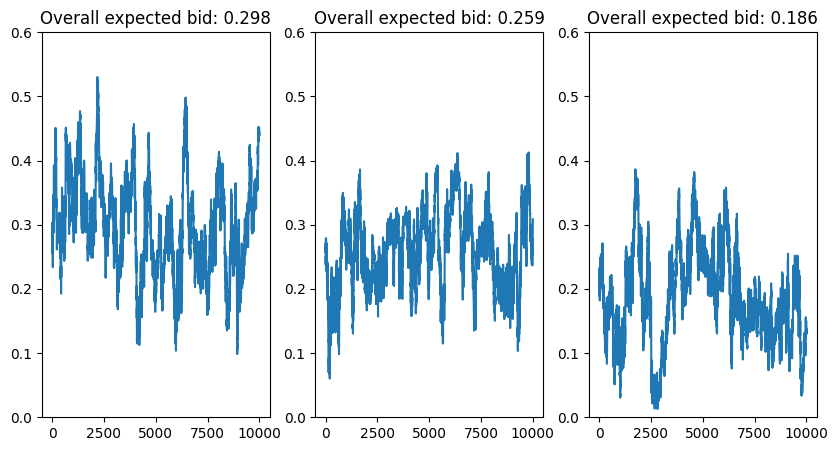

In [10]:
plot_expected_bid_over_time(bidders)

# Problem 2


## Problem 2.1 Implement the VCG Auction Rules

Now implement what would the VCG mechanism do in this setting. The allocation should be the same, but the payment rule should be different. In particular, now the bidders will be asked to pay some amount $p_i$ (for simplicity, irrespective of click or not) and if bidder $i$ is assigned slot $j$ they will have utility:
\begin{align}
u_i = a_j \cdot s_i \cdot v_i - p_i
\end{align}
The payment $p_i$ needs to be calculated based on the VCG logic. You have to calculate how much expected welfare the rest of the bidders receive if the bidder had not been there and how much expected welfare they receive when the bidder is there. Note that bidders that are allocated in slots above $j$ are not affected by the bidder vanishing. Thus we can restrict this externality calculation only to bidders that appear in slot below slot $j$.

Note that all these bidders now get welfare $\sum_{j'>j} a_{j'} s_{I(j')} v_{I(j')}$, where $I(j)$ is the index of the bidder assigned in slot $j$. If bidder $i$ vanishes, then all these bidders will go up a slot and get more welfare. Using this reasoning, calculate the externality of bidder $i$ and set this as their payment $p_i$.

In [11]:
def vcg(bidder_scores, bids):
    ''' (2 points) Exectutes the VCG auction with bidder quality scores and bids.
    Returns the utility of each bidder. '''
    # rank bidders based on bids * bidder_score (descending order)
    # calculate the score weighted bids: score * bid
    wbids = bidder_scores * bids
    # calculate which bidder is placed on each slot
    # Hint: use argsort. Argsort(a) returns an array index, such that a[index]
    # is sorted in increasing order. So index[0] can be viewed as the index
    # of the lowest element of a, index[1] as the index of the second lowest
    # element of a, etc.
    # in the end allocated_bidder[j] should contain the index of the bidder
    # that was allocated slot j.
    allocated_bidder = np.argsort(wbids)[::-1]

    # find the utility for the bidders
    bidder_click_prob = bidder_scores.copy()
    for i in range(len(bidder_scores)):
      bidder_click_prob[allocated_bidder[i]] = bidder_click_prob[allocated_bidder[i]] * CLICK_PROB[i]

    # calculate the expected value that each player receives,
    # i.e. Pr(click) * value
    evalues = bidder_click_prob * VALUES

    # calculate the VCG payments using the externality logic
    payments = np.zeros(N)
    for j in range(N): # loop over slots
        bidderj = allocated_bidder[j] # bidder allocated in slot j
        # calculate how much total value, i.e.,
        #   total probability of click * value-per-click
        # the other bidders that currently appear in slots below j
        # would get if bidderj was not there.
        # Note that each bidder in slots below would be bumped up by one slot
        # compared to their current allocation
        # Compared to the slides, the only extra complication here is the scores
        # however, you should think as the score * bid to be the "bid" of the
        # bidder in the calculation that we did in class. So simply do the
        # calculation we did in class but using the "score weighted bids",
        # instead of the bids.

        others_without_me = 0
        for i, c in enumerate(allocated_bidder):
          if i > j:
            others_without_me += bidder_scores[c] * CLICK_PROB[i-1] * bids[c]


        # calculate how much total value the other bidders that are allocated
        # in slots below j are currently getting when bidderj is still here
        others_with_me = 0
        for i, c in enumerate(allocated_bidder):
          if i > j:
            others_with_me += bidder_scores[c] * CLICK_PROB[i] * bids[c]

        # calculate the externality of bidderj (i.e. the bidder allocated in
        # slot j). Note that bidders allocated in slots above j are not affected
        # by bidderj leaving, so we can omit their values in the calculations
        # above for others_without_me and others_with_me
        externality = others_without_me - others_with_me
        payments[bidderj] = externality
    # calculate utility as evalue minus payment
    utilities = evalues - payments

    # calculate welfare, which should be the total of the evalues
    welfare = np.sum(evalues)

    # calculate revenue, which should be the total of the payments
    revenue = np.sum(payments)

    return utilities, welfare, revenue

## Problem 2.2 Run the Simulation and Examine the Results; Compare with Truthful Bidding

At the end discuss how much utility the bidders get, when using no-regret learning and how utility do they get under truthful bidding. Similarly, how much revenue does the auctioneer get. Discuss what could be the reason of these differences, to the best of your ability. Hypothesize what could be happening when bidders are learning and allows them to extract more or less utility and hence either increase or decrease the auctioneer's welfare. Also compare the revenue, utility and welfare in the simulations here, with the revenue, utility and welfare in the simulations you run for the GFP. When using learning, do bidders tend to bid higher or lower under the GFP or under the VCG. Do bidders bid more or less under VCG, when they perform learning or under truthful reporting and approximately by how much.

In [12]:
# define what auction we are running
auction = vcg
# define a class for each bidder
bidders = [Bidder(v, T) for v in VALUES]
metrics = run_dynamics(auction, bidders)
print_metrics(metrics)

Average total welfare is: 0.286
Average bidder 0 utility is: 0.100
Average bidder 1 utility is: 0.052
Average bidder 2 utility is: 0.027
Average revenue is: 0.106
Average optimal welfare is: 0.309
Average regret is: [0.024 0.023 0.013]


You should be getting the following results when executing the cell above (up to small deviations)
```
Average total welfare is: 0.287
Average bidder 0 utility is: 0.101
Average bidder 1 utility is: 0.054
Average bidder 2 utility is: 0.026
Average revenue is: 0.105
Average optimal welfare is: 0.309
Average regret is: [0.025 0.023 0.014]
```

Expected bid at each period:


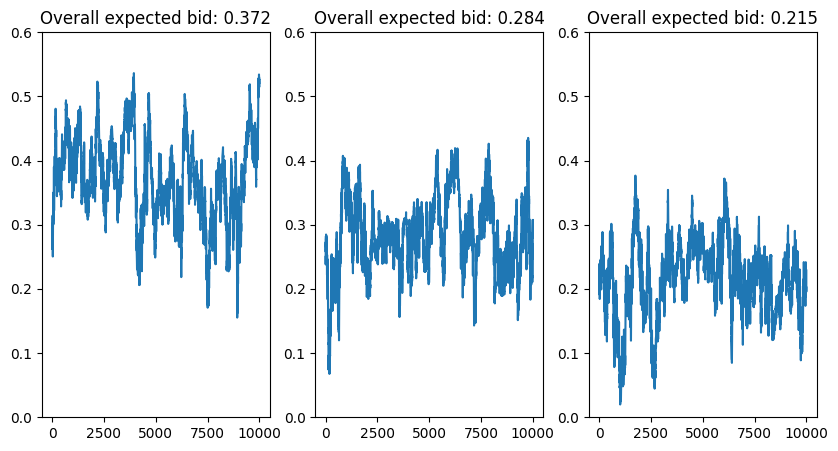

In [ ]:
plot_expected_bid_over_time(bidders)

In [ ]:
class TruthfulBidder():
    def __init__(self, value, T):
        # (int) represents value per click for the bidder
        self.value = value
        # set of discrete bids the bidder can bid, from [0, value + 0.1] with
        # step size 0.1
        self.bids = np.arange(0, value + 0.1, 0.1)
        # number of possible actions for the bidder
        self.num_actions = len(self.bids)
        # this bidder will always be playing their value
        self.strategies = np.zeros((T+1, self.num_actions)) * 1 / self.num_actions
        bid_index = np.argwhere(np.isclose(self.bids, self.value))[0, 0]
        self.strategies[:, bid_index] = 1
        # counter to keep track of the current bid's time
        self.current_time = 0
        # store welfare
        self.total_utility = 0

    def update(self, utility, bid):
        ''' A truthfull bidder always plays their value '''
        # increment time
        self.current_time += 1
        t = self.current_time
        # keep track of total utility of bidder
        # update by adding the current utility to the total utility
        self.total_utility += utility
        return self

    def get_bid(self):
        # generates a bid randomly based on the previous time period's strategy
        action = np.random.choice(self.num_actions, p=self.strategies[self.current_time])
        return self.bids[action]

    def get_average_strategy(self):
        # returns average of all strategy
        return np.mean(self.strategies, axis=0)

    def get_avg_utility(self):
        # returns average utility per time period
        return self.total_utility / self.current_time

In [ ]:
# define what auction we are running
auction = vcg
# define a class for each bidder
bidders = [TruthfulBidder(v, T) for v in VALUES]
metrics = run_dynamics(auction, bidders)

In [ ]:
print_metrics(metrics)

Average total welfare is: 0.309
Average bidder 0 utility is: 0.058
Average bidder 1 utility is: 0.022
Average bidder 2 utility is: 0.003
Average revenue is: 0.226
Average optimal welfare is: 0.309
Average regret is: [0. 0. 0.]


You should be getting the following results when executing the cell above (up to small deviations)
```
Average total welfare is: 0.309
Average bidder 0 utility is: 0.058
Average bidder 1 utility is: 0.022
Average bidder 2 utility is: 0.003
Average revenue is: 0.226
Average optimal welfare is: 0.309
Average regret is: [0. 0. 0.]
```

Expected bid at each period:


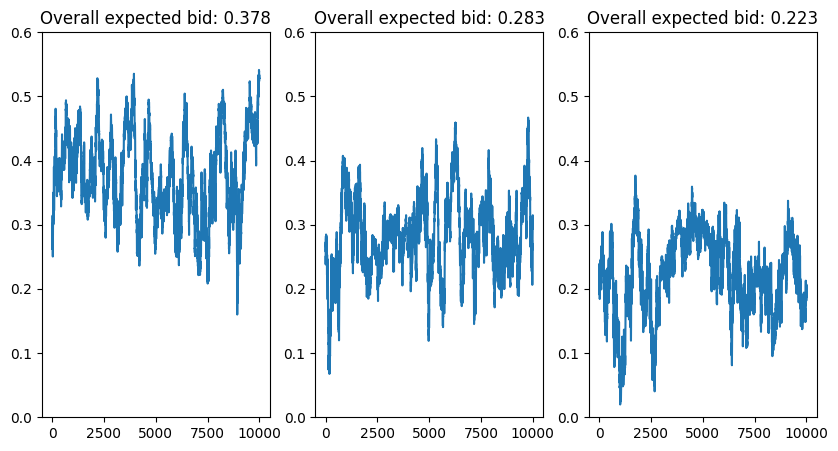

In [13]:
plot_expected_bid_over_time(bidders)

### Answer. Put your answer to the discussion requested here